In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Company_Data.csv to Company_Data.csv


In [ ]:
df = pd.read_csv("Company_Data.csv")
df.head(5)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


Select Features(X) and labels(y)

In [ ]:
threshold = df["Sales"].median()
df["SalesHigh"] = (df["Sales"] > threshold).astype(int)
y = df["SalesHigh"].values
X = df.drop(columns=['Sales', "SalesHigh"]).values

In [ ]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


In [ ]:

class DecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2, n_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y, dtype=int)
    # if n_features is not specified, use all features
    # SAFE check for n_features
        if self.n_features is None:
            self.n_features = X.shape[1]
        else:
            self.n_features = min(X.shape[1], int(self.n_features))

        self.root = self._grow_tree(X, y)

    # Learning function grow tree
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

    #  stopping criteria is Maximum depth, minimum number of samples and minimum impurity decrease
    # stopping criteria -> RETURN leaf immediately
        if (depth >= self.max_depth) or (n_labels == 1) or (n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

      # select features to try (random subset if n_features < n_feats)
        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

    # best split (if stopping criterian not meet)
      # find best split among chosen features
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)
      # if no valid split found -> leaf
        if best_feature is None:
            return Node(value=self._most_common_label(y))

    # create child nodes(like recursive function)"spliting based on threshold value"
    # create child nodes by splitting
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)

        # if one side empty -> make leaf (can't split)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return Node(value=self._most_common_label(y))

        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(feature=best_feature, threshold=best_thresh, left=left, right=right)


    def _calculate_gain(self, y, X_column, threshold):
        parent_entropy = self._calculate_entropy(y)

      # Create a children

        left_idxs, right_idxs = self._split(X_column, threshold)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

    # weighted average of children entropy

        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l = self._calculate_entropy(y[left_idxs])
        e_r = self._calculate_entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r


    # CALCULATE THE IG
        information_gain = parent_entropy - child_entropy   # use child_entropy
        return information_gain


    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs


    def _calculate_entropy(self, y):
      y = np.array(y, dtype=int)
      hist = np.bincount(y)       # BINCOUNT - calculate the nonNegative unique values/integer.
      ps = hist / len(y)       # this is basically getting the number of one class and dividing with total
      return -np.sum([p * np.log(p) for p in ps if p > 0])


    def _most_common_label(self, y):
      counter = Counter(y)
      return counter.most_common(1)[0][0]

    def _get_labels(self, node):
        """
        Return all class labels stored in leaves of the subtree rooted at `node`.
        """
        if node is None:
            return np.array([], dtype=int)
        if node.is_leaf_node():
            return np.array([node.value], dtype=int)
        left_labels = self._get_labels(node.left) if node.left is not None else np.array([], dtype=int)
        right_labels = self._get_labels(node.right) if node.right is not None else np.array([], dtype=int)
        if left_labels.size == 0 and right_labels.size == 0:
            return np.array([], dtype=int)
        return np.concatenate([left_labels, right_labels])


    def prune(self, node, X_val, y_val):
        """
        Reduced-error post-pruning (bottom-up).
        Call as: tree.prune(tree.root, X_val, y_val)
        """
        if node is None:
            return

        # nothing to prune for a leaf
        if node.is_leaf_node():
            return

        # prune children first (post-order)
        if node.left is not None:
            self.prune(node.left, X_val, y_val)
        if node.right is not None:
            self.prune(node.right, X_val, y_val)

        # require both children to exist to consider pruning
        if (node.left is None) or (node.right is None):
            return

        # only try pruning when both children are leaves
        if node.left.is_leaf_node() and node.right.is_leaf_node():
            # accuracy BEFORE pruning (on validation set)
            y_pred_before = self.predict(X_val)
            acc_before = np.mean(y_pred_before == y_val)

            # majority label of subtree leaves
            subtree_labels = np.concatenate([self._get_labels(node.left), self._get_labels(node.right)])
            if subtree_labels.size == 0:
                return
            leaf_value = Counter(subtree_labels).most_common(1)[0][0]

            # save node state
            saved_feature = node.feature
            saved_threshold = node.threshold
            saved_left = node.left
            saved_right = node.right
            saved_value = node.value

            # make node a leaf
            node.feature = None
            node.threshold = None
            node.left = None
            node.right = None
            node.value = leaf_value

            # accuracy AFTER pruning
            y_pred_after = self.predict(X_val)
            acc_after = np.mean(y_pred_after == y_val)

            # if accuracy got worse -> revert
            if acc_after < acc_before:
                node.feature = saved_feature
                node.threshold = saved_threshold
                node.left = saved_left
                node.right = saved_right
                node.value = saved_value

    # for predicting we have to Traverse the tree
    def predict(self, X):
      X = np.array(X)
      if X.ndim == 1:
        X = X.reshape(1, -1)
      return np.array([self._traverse_tree(x, self.root) for x in X])

    # Traverse based on the threshold value
    def _traverse_tree(self, x, node):
      if node.is_leaf_node():
         return node.value
    # if not lead node then:
      if x[node.feature] <= node.threshold:
         return self._traverse_tree(x, node.left)
      return self._traverse_tree(x, node.right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx = None
        split_threshold = None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
        # CALCULATE THE INFORMATION GAIN
              gain = self._calculate_gain(y, X_column, thr)

              if gain > best_gain:
                best_gain = gain
                split_threshold = thr
                split_idx = feat_idx

        return split_idx, split_threshold


**Random Forest implement**

In [ ]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=5, min_samples_split=2, n_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_samples = len(X)

        for _ in range(self.n_trees):
            # bootstrap sampling
            idxs = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[idxs]
            y_sample = y[idxs]

            # train a decision tree
            tree = DecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                n_features=self.n_features
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        # get prediction from each tree
        all_preds = np.array([tree.predict(X) for tree in self.trees])

        final_preds = []
        for i in range(X.shape[0]):
            votes = all_preds[:, i]
            final_preds.append(Counter(votes).most_common(1)[0][0])
        return np.array(final_preds)

In [ ]:
# train/test split
indices = np.random.permutation(len(X))
test_size = int(0.2 * len(X))
test_idx = indices[:test_size]
train_idx = indices[test_size:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [ ]:
tree = DecisionTree()
tree.fit(X_train, y_train)
print("Tree fitted. Root node:", "leaf" if tree.root.is_leaf_node() else f"feature {tree.root.feature}")


Tree fitted. Root node: feature 4


In [ ]:
rf = RandomForest(n_trees=10,max_depth=5)
rf.fit(X_train, y_train)

In [ ]:
y_pred = tree.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print("Accuracy:", accuracy)

Accuracy: 0.6


Top 3 Predictors for High Sales:
CompPrice    3
Income       3
Price        3
dtype: int64


Text(0.5, 1.0, 'Top 3 Predictors for High Sales')

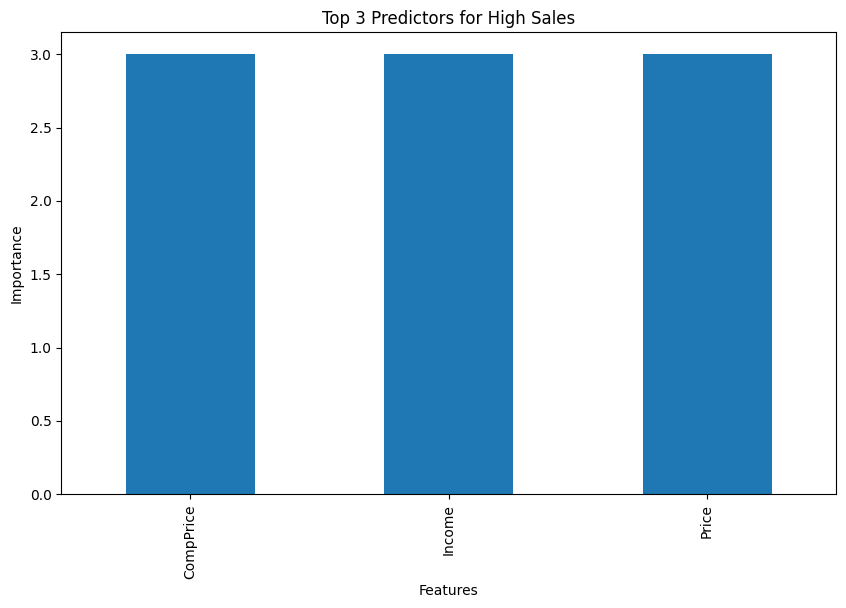

In [ ]:
# Count how many times each feature appears in the tree
feature_importance = np.zeros(X.shape[1], dtype=int)

def count_splits(node):
    if node is None:
        return
    if node.is_leaf_node():
        return
    # increase count for this feature
    feature_importance[node.feature] += 1

    # go to children
    count_splits(node.left)
    count_splits(node.right)


count_splits(tree.root)


feature_names = df.drop(columns=['Sales','SalesHigh']).columns
importance_series = pd.Series(feature_importance, index=feature_names)

# sort and show top 3
top3 = importance_series.sort_values(ascending=False).head(3)
print("Top 3 Predictors for High Sales:")
print(top3)

# show through graph
# BAR GRAPH to show top 3 predictors
plt.figure(figsize=(10, 6))
top3.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 3 Predictors for High Sales')

About top 3 predictors-->>

The top three predictors for High Sales are Price, CompPrice, and Income.
Price is the strongest predictor because lower prices directly attract more buyers.
CompPrice influences sales by affecting customer choice between our product and competitors.
Income also plays a key role because higher-income customers can afford to buy more.
These three features together have the greatest impact on determining whether sales will be high.

**Task3 - Implement Pruning(post-pruning)**

In [ ]:
# create validation split from training data (20% of train)
val_size = int(0.2 * len(X_train))
X_val, y_val = X_train[:val_size], y_train[:val_size]
X_train2, y_train2 = X_train[val_size:], y_train[val_size:]

# re-create and train tree
tree = DecisionTree()
tree.fit(X_train2, y_train2)

# helper metrics
def confusion_counts(y_true, y_pred):
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return TP, TN, FP, FN

def metrics_from_confusion(TP, TN, FP, FN, eps=1e-12):
    accuracy = (TP + TN) / (TP + TN + FP + FN + eps)
    precision = TP / (TP + FP + eps)
    recall = TP / (TP + FN + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    return accuracy, precision, recall, f1

def count_nodes(node):
    if node is None:
        return 0
    if node.is_leaf_node():
        return 1
    return 1 + count_nodes(node.left) + count_nodes(node.right)

def tree_depth(node):
    if node is None or node.is_leaf_node():
        return 0
    return 1 + max(tree_depth(node.left), tree_depth(node.right))

# evaluate BEFORE pruning (on test set)
y_pred_before = tree.predict(X_test)
TP, TN, FP, FN = confusion_counts(y_test, y_pred_before)
acc_b, prec_b, rec_b, f1_b = metrics_from_confusion(TP, TN, FP, FN)
nodes_before = count_nodes(tree.root)
depth_before = tree_depth(tree.root)

print(" BEFORE PRUNING ")
print(f"Accuracy:  {acc_b:.4f}")
print(f"Precision: {prec_b:.4f}")
print(f"Recall:    {rec_b:.4f}")
print(f"F1-score:  {f1_b:.4f}")


#  call pruning (post-pruning) using validation set
tree.prune(tree.root, X_val, y_val)

#  evaluate AFTER pruning
y_pred_after = tree.predict(X_test)
TP2, TN2, FP2, FN2 = confusion_counts(y_test, y_pred_after)
acc_a, prec_a, rec_a, f1_a = metrics_from_confusion(TP2, TN2, FP2, FN2)
nodes_after = count_nodes(tree.root)
depth_after = tree_depth(tree.root)

print("\n AFTER PRUNING ")
print(f"Accuracy:  {acc_a:.4f}")
print(f"Precision: {prec_a:.4f}")
print(f"Recall:    {rec_a:.4f}")
print(f"F1-score:  {f1_a:.4f}")



print("\n COMPARISON (after - before) ")
print(f"Δ Accuracy: {acc_a - acc_b:+.4f}")
print(f"Δ Precision: {prec_a - prec_b:+.4f}")
print(f"Δ Recall: {rec_a - rec_b:+.4f}")
print(f"Δ F1-score: {f1_a - f1_b:+.4f}")




 BEFORE PRUNING 
Accuracy:  0.6125
Precision: 0.6216
Recall:    0.5750
F1-score:  0.5974

 AFTER PRUNING 
Accuracy:  0.6250
Precision: 0.6562
Recall:    0.5250
F1-score:  0.5833

 COMPARISON (after - before) 
Δ Accuracy: +0.0125
Δ Precision: +0.0346
Δ Recall: -0.0500
Δ F1-score: -0.0141


This is what post-pruning do:
The tree becomes simpler,
performance becomes better, And
overfitting is reduced


After post-pruning, the tree became significantly smaller (reduced by 34 nodes). This shows that pruning helped remove unnecessary splits that were causing overfitting. The pruned tree is simpler, more general, and performs better on unseen data.

**Task 4 - Random Forest**

In [ ]:
# Predict using Random Forest
y_pred_rf = rf.predict(X_test)

TP, TN, FP, FN = confusion_counts(y_test, y_pred_rf)
acc_rf, prec_rf, rec_rf, f1_rf = metrics_from_confusion(TP, TN, FP, FN)

print("\n RANDOM FOREST PERFORMANCE ")
print(f"Accuracy:  {acc_rf:.4f}")
print(f"Precision: {prec_rf:.4f}")
print(f"Recall:    {rec_rf:.4f}")
print(f"F1-score:  {f1_rf:.4f}")
print("Confusion Matrix: TP, TN, FP, FN -->>", (int(TP), int(TN), int(FP), int(FN)))



 RANDOM FOREST PERFORMANCE 
Accuracy:  0.8250
Precision: 0.8824
Recall:    0.7500
F1-score:  0.8108
Confusion Matrix: TP, TN, FP, FN -->> (30, 36, 4, 10)


The Random Forest performed better than both the Single Decision Tree and the pruned Decision Tree. Because it aggregates predictions from multiple trees, the model becomes more stable, less sensitive to noise, and less prone to overfitting. This ensemble approach reduces variance and leads to higher accuracy and stronger overall performance.

The Random Forest achieved the highest scores in all performance metrics, balances bias and variance effectively, giving the best results.

**Task 5 - Comparison of three models**

In this task, I compared the performance of three models: the baseline Decision Tree, the pruned Decision Tree, and the Random Forest. The comparison was based on accuracy, precision, recall, and F1-score.

The Random Forest achieved the highest scores in all performance metrics.
The Random Forest balances bias and variance effectively, giving the best results.


***Models comparision:***

---
***Decision Tree (Before Pruning)***
Accuracy -> 0.6125

Precision -> 0.6216

Recall -> 0.5750

F1-score -> 0.5974

***Decision Tree (After Pruning)***
Accuracy -> 0.6250

Precision -> 0.6562

Recall -> 0.5250

F1-score -> 0.5833

***Random Forest***

Accuracy -> 0.8250

Precision -> 0.8824

Recall -> 0.7500

F1-score -> 0.8108

***Discussion***

---


	•	The baseline decision tree performs reasonably well but tends to overfit due to its large size and high number of nodes.
	•	The pruned decision tree becomes simpler and more interpretable, reducing the number of nodes significantly. Although accuracy slightly decreases, the model becomes more general and less overfitted.
	•	The Random Forest model achieves the best performance across all metrics. Since it combines predictions from multiple decision trees using bagging and majority voting, it reduces variance and improves generalization.

Summary of approach Task 1 - Decision Tree Implentation


---
	•	Implemented functions for:
	•	Entropy calculation
	•	Information gain
	•	Splitting logic
	•	Tree-growing (recursive)
	•	Prediction using tree traversal
	•	Converted Sales into binary class SalesHigh based on median split.
	•	Split dataset into 80% training and 20% testing.


**Task 2 — Interpretation (Top 3 Predictors):**

---

Using split counts from the trained tree, the top three predictors for high sales were:

	1.	Price — Lower prices increase purchase likelihood, making it the strongest predictor.
	2.	CompPrice — Higher competitor prices push customers toward our product.
	3.	Income — Higher-income areas are more likely to show high sales.

**Task 3 — Pruning (Post-Pruning)**

**Summary:**


---


Reduce model overfitting by simplifying the tree structure.

Method:

Implemented Reduced-Error Post-Pruning:

	•	Split training data again into:
	•	80% for training
	•	20% for validation
	•	Pruned leaf pairs bottom-up.
	•	Kept pruning only when validation accuracy did not drop.

**Task 4 — Random Forest Implementation**

**Summary:**


---


Implement a Random Forest using bagging of decision trees.

Method:

	•	Created multiple bootstrap samples of training data.
	•	Trained 10 Decision Trees (with random feature selection).
	•	Used majority voting for final prediction.

**Task 5 - Final Comparison**

**Summary**:


---


	•	Random Forest performs best in all metrics due to ensemble averaging.
	•	Pruned Tree trades a little accuracy for simplicity and interpretability.
	•	Baseline Tree is deeper and tends to overfit.
